# Titanic Data Science Tutorial

There are several excellent notebooks to study data science competition entries. However many will skip some of the explanation on how the solution is developed

# Question or Problem Definition

Goal: Predict whether a passenger survived or not on the Titanic.

Type: Binary classification problem.

Target variable: Survived (0 = No, 1 = Yes)

# Wrangle, Prepare, Cleanse the Data

andling Missing Data:

Filled missing Age with median.

Filled missing Embarked with mode.

Dropped or filled Cabin based on strategy.



# Feature Engineering

xtracted Title from Name.

Created FamilySize from SibSp + Parch + 1.

Created binary IsAlone feature.

Converted Sex and Embarked to numeric.

# Analyze, Identify Patterns, and Explore the Data

Correlation matrix and heatmaps.

Grouped data by survival to inspect features’ importance.

Insights:

Females had higher survival rates.

Higher classes (Pclass=1) were more likely to survive.

Family presence and younger age also increased survival likelihood.



# Model, Predict, and Solve the Problem

Models Used:

Logistic Regression

Support Vector Classifier (SVC)

K-Nearest Neighbors (KNN)

Random Forest Classifier

Gradient Boosting Classifier

Validation:

Split data into training/validation using cross-validation.

Tuned hyperparameters using GridSearchCV.

Evaluation Metrics:

Accuracy, Precision, Recall, F1 Score, and Confusion Matrix.

We may also want to develop some early understanding about the domain of our problem. This is described on the Kaggle competition description page here. Here are the highlights to note.

On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. Translated 32% survival rate.
One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew.
Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In [1]:
#Importing Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#For Dnn
import tensorflow as tf
#i will use some of Classification Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#for feature selecting using model and kbest for linear model
from sklearn.feature_selection import SelectKBest, f_classif,RFECV
#PCA for svc
from sklearn.decomposition import PCA
#for scaling and encoding
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,PolynomialFeatures
# for Hyperparameters
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline
#For splitind Data
from sklearn.model_selection import train_test_split,cross_val_score

#To see model Result
from sklearn.metrics import precision_recall_fscore_support,accuracy_score,confusion_matrix


## Load Train and Test Data

In [3]:

train=pd.read_csv('datasets/titanic/train.csv')
test=pd.read_csv('datasets/titanic/test.csv')
#see information about data 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### After run the previous cell we can have some imoprtant information about data 
* the data has 12 columns and 981 entries(row)
* the columns Age and Embarked has a few null values
* the column Cabin has a huge null values
* the data has :
  * Two float columns 
  * Five int columns
  * Five object columns

Now lets see some statistic information about data

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


we can see the min and max value of the column age and we can also see the mean if we fill the null value with the mean 
we can also see the std for the age 
so we know that std is 14 and mean is 30 so the so we can know that ages of passengers between (16->44)years

lets compare every columns with Survived columns and the the result

In [9]:
#first see the first 5 row to know what we are working with 
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Understand Columns 

In [11]:
train[['Survived','Pclass']].groupby('Pclass',as_index=False).mean().sort_values('Survived',ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


we can see that 

* First class 62% Survived
* Second class 47% Survived
* Third class 24% Survived

so the vip class passenger have more chance to Survive than the economy class

In [13]:
train[['Survived','Sex']].groupby('Sex',as_index=False).mean().sort_values('Survived',ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


we can see that 

* Female 74% Survived
* Male 18% Survived


so the Females have more chance to Survive

In [15]:
train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


we can see that the less sib do you have the more chance to live 

In [17]:
train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


# Analyze by visualizing data

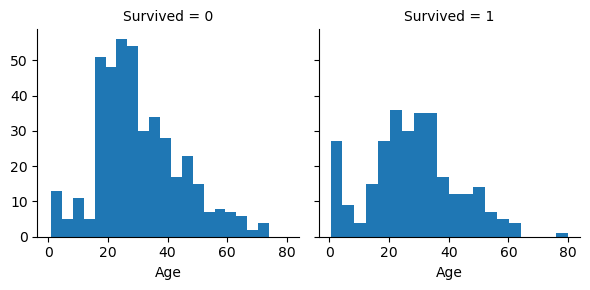

In [19]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()


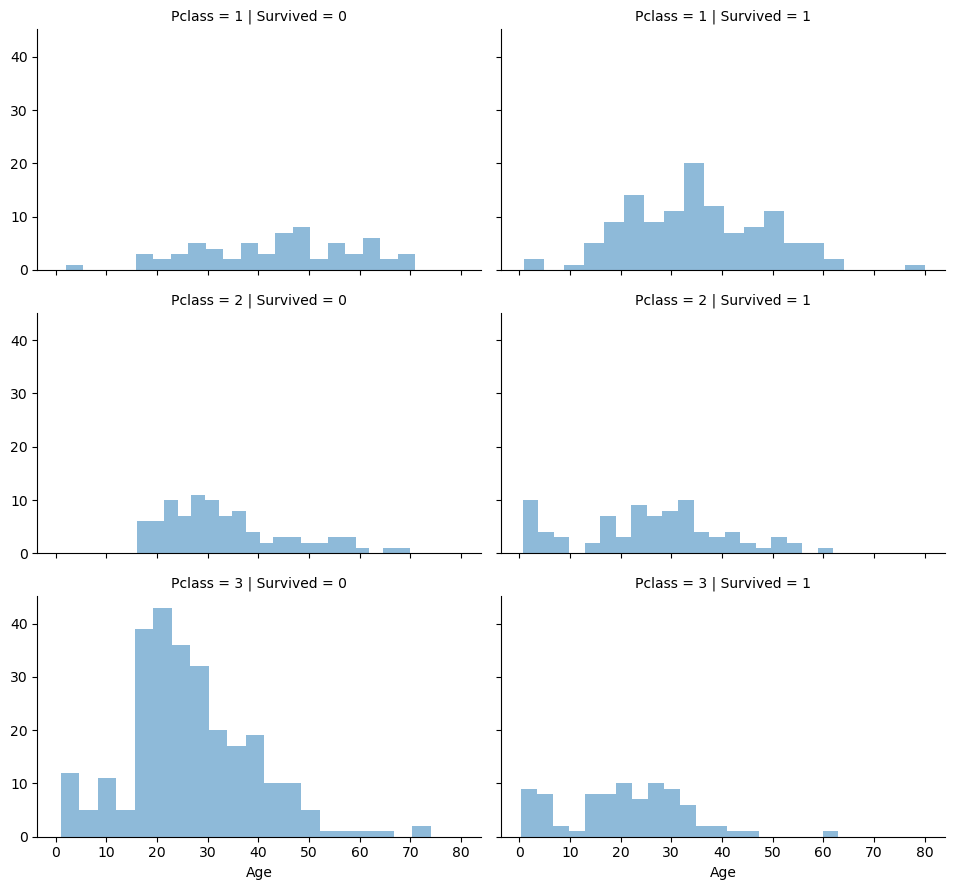

In [20]:
grid=sns.FacetGrid(train,col='Survived',row='Pclass', aspect=1.6)
grid.map(plt.hist,'Age',alpha=0.5,bins=20)
grid.add_legend()
plt.show()

C:\Users\elect\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\elect\anaconda3\Lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


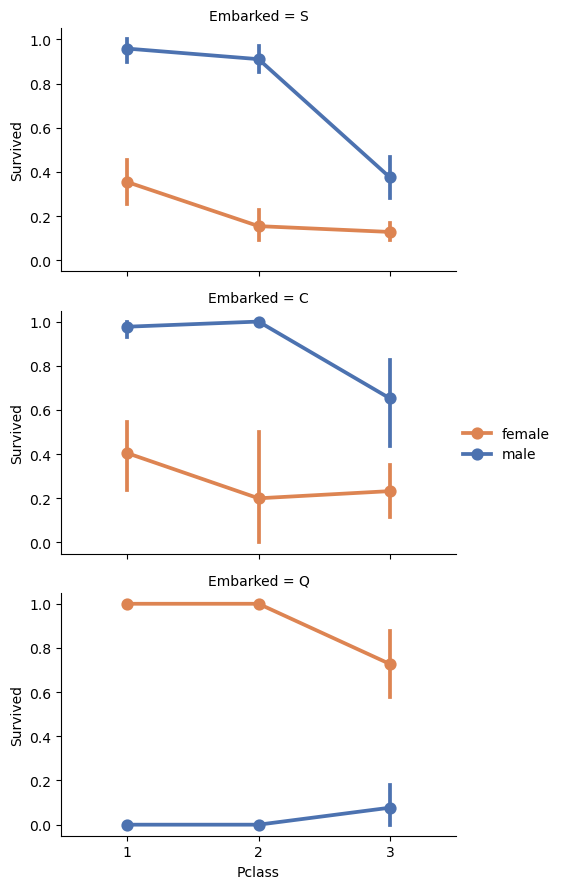

In [21]:
grid = sns.FacetGrid(train, row='Embarked',  aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()
plt.show()

# Fix missing data 

we will try to fix data for training and testing data

In [24]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


so we can drop Cabin from train and test data and i will delete the two null row(on embarked column) from training data also we will fill the age columns with the same mean on train and test data  

In [26]:
mean=train['Age'].mean()
train['Age']=train['Age'].fillna(mean)
test['Age']=test['Age'].fillna(mean)
#check if that work
print('Age train data: ',train['Age'].isnull().sum())
print('Age test data: ',test['Age'].isnull().sum())

Age train data:  0
Age test data:  0


In [27]:
#i will drop the Cabin and i will drop the null row i Embarked
train=train.dropna(subset=['Embarked'],axis=0)
train=train.drop(columns='Cabin')
test=test.drop(columns='Cabin')
#Check if that work
print('info train data: ',train.info())
print('-----------------------------------')
print('info test data: ',test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB
info train data:  None
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 

Oh I didn’t realize the Fare column had one null value I will fill it

first will see the skew for this column if it is larger than 1 i will fill it useing median 

In [30]:
if test['Fare'].skew() > 1:
    test['Fare']=test['Fare'].fillna(test['Fare'].median())
else:
    test['Fare']=test['Fare'].fillna(test['Fare'].mean())
#Check if it work
test['Fare'].isnull().sum()

0

# Feature Engineering

we know that parch columns for children and parents and the SibSp is for Siblings lets merge them in one columns and name it family
the we will add to them one for two reasons

+ First i want to count the passenger him self because the new column is the family size
+ Second and the main reasons i want to avoid the risk of redundant info 

In [33]:
train['Family']=train['Parch']+train['SibSp']+1 # parch +sibsp + passenger him self 
test['Family']=test['Parch']+test['SibSp']+1 # parch +sibsp + passenger him self 
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1


i will fix the skew column too in train data and the test data without touching the target column so we know that test data doesn't have the target so we will take the columns name from it

In [35]:
numcol=test.select_dtypes(include=['number'])#filter for numeric columns
numcol=numcol.drop(columns='PassengerId')#we don't want to play with there id
cols=numcol.columns.tolist()

for col in cols:
    # Make sure values are non-negative before applying log1p
    if (train[col] >= 0).all() and (test[col] >= 0).all():
        if train[col].skew()>1:
            train[col]=np.log1p(train[col])
            test[col]=np.log1p(test[col])

# Encoding Feature 

we will use OneHotEncoder for categories column like Sex and Embarked i think iwill drop the ticket because this columns have a hundred of  unique values
and for name columns i think i will extract from it feature then encoded i think we can use it 

In [38]:
#drop ticket column
train=train.drop(columns='Ticket')
test=test.drop(columns='Ticket')
import re
#extract title from name columns
def title(name):
    match=re.search(r',\s([^\.]*)\.',name)
    if match:
        return match.group(1).strip()#strip clean every space before and after the title
    else:
        return 'Unknown'
train['title']=train['Name'].apply(title)
test['title']=test['Name'].apply(title)

now we can drop name column from the train and test datasets

In [40]:
train=train.drop(columns='Name')
test=test.drop(columns='Name')

#check if it drop and see our new column
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,title
0,1,0,3,male,22.0,0.693147,0.0,2.110213,S,1.098612,Mr
1,2,1,1,female,38.0,0.693147,0.0,4.280593,C,1.098612,Mrs
2,3,1,3,female,26.0,0.000000,0.0,2.188856,S,0.693147,Miss
3,4,1,1,female,35.0,0.693147,0.0,3.990834,S,1.098612,Mrs
4,5,0,3,male,35.0,0.000000,0.0,2.202765,S,0.693147,Mr


In [41]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,title
0,892,3,male,34.5,0.000000,0.000000,2.178064,Q,0.693147,Mr
1,893,3,female,47.0,0.693147,0.000000,2.079442,S,1.098612,Mrs
2,894,2,male,62.0,0.000000,0.000000,2.369075,Q,0.693147,Mr
3,895,3,male,27.0,0.000000,0.000000,2.268252,S,0.693147,Mr
4,896,3,female,22.0,0.693147,0.693147,2.586824,S,1.386294,Mrs


now lets use OneHotEncoder to encode the title and sex and embarked columns

In [43]:
encoder=OneHotEncoder(handle_unknown='ignore',sparse_output=False)# handle_unknown='ignore' to avoid errors

train_encoded=encoder.fit_transform(train[['Sex','Embarked','title']])
test_encoded=encoder.transform(test[['Sex','Embarked','title']])

#get new columns name
encoded_col=encoder.get_feature_names_out(['Sex','Embarked','title'])

#convert to dataframe
train_encoded_df=pd.DataFrame(train_encoded,columns=encoded_col,index=train.index)
test_encoded_df=pd.DataFrame(test_encoded,columns=encoded_col,index=test.index)
#drop and join the new columns
train=train.drop(columns=['Sex','Embarked','title']).join(train_encoded_df)
test=test.drop(columns=['Sex','Embarked','title']).join(test_encoded_df)


lets see the five row for the train and test dataframe to see the encoded columns

In [45]:
train.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Family,Sex_female,Sex_male,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,1,0,3,22.0,0.693147,0.0,2.110213,1.098612,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1,1,38.0,0.693147,0.0,4.280593,1.098612,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,1,3,26.0,0.000000,0.0,2.188856,0.693147,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,1,35.0,0.693147,0.0,3.990834,1.098612,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,0,3,35.0,0.000000,0.0,2.202765,0.693147,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [46]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Family,Sex_female,Sex_male,Embarked_C,...,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,title_the Countess
0,892,3,34.5,0.000000,0.000000,2.178064,0.693147,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,893,3,47.0,0.693147,0.000000,2.079442,1.098612,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,894,2,62.0,0.000000,0.000000,2.369075,0.693147,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,895,3,27.0,0.000000,0.000000,2.268252,0.693147,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,896,3,22.0,0.693147,0.693147,2.586824,1.386294,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


After encoding i will check if there any different on train and test columns


In [48]:
train_col=train.columns.tolist()
test_col=test.columns.tolist()
diff_col=list(set(train_col)-set(test_col))
diff_col

['Survived']

now lets use StandardScaler because logisticregression,SVC,KNN is more sensitive for scaled data because they use Gradient Descent optimization

* Gradient Descent Convergence  Features on different scales can cause slow or unstable convergence.
* Regularization Impact  L1/L2 penalties penalize large coefficients so unscaled features may dominate unfairly.

In [50]:
train_passid=train['PassengerId']
test_passid=test['PassengerId']
train=train.drop(columns='PassengerId')
test=test.drop(columns='PassengerId')
scaler=StandardScaler()
train_without_survived=train.drop(columns='Survived')#it must be the same columns before we use scaler so we drop survived
scaler.fit(train_without_survived)#fit only on train data to avoid data Leakage
train_scaled=scaler.transform(train_without_survived)
test_scaled=scaler.transform(test)

In [51]:
target=train['Survived']

lets see the correlation between feature and use some model to select the best feature that i need

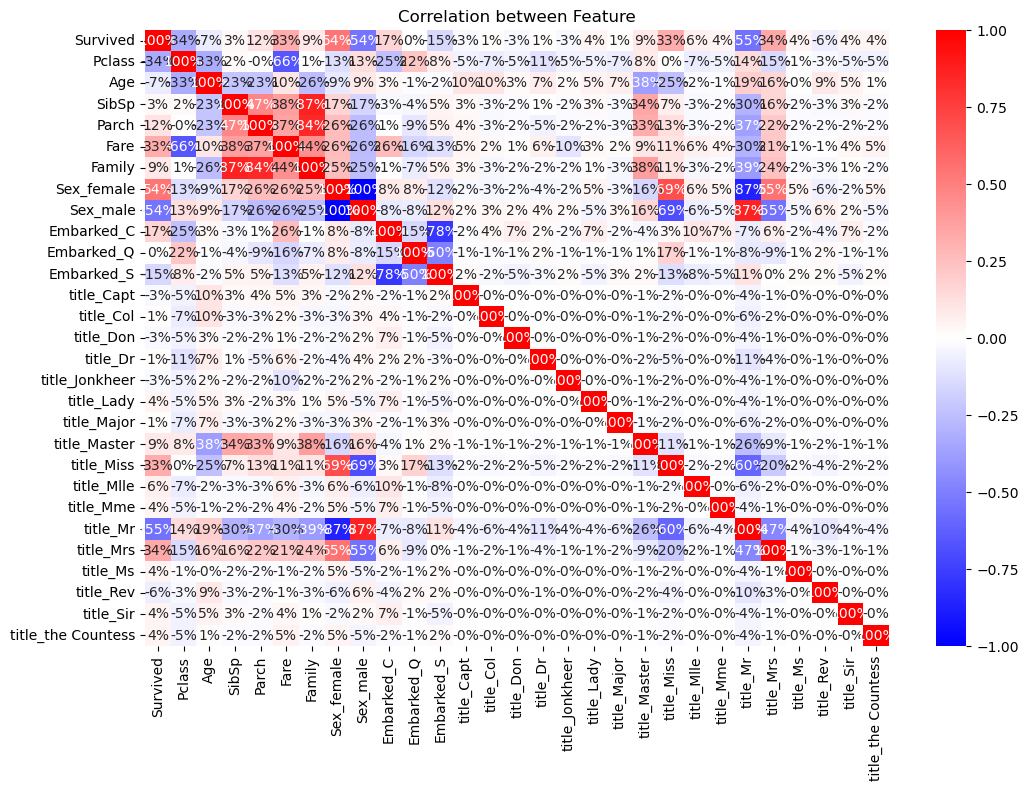

In [53]:
corr=train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr,cmap='bwr',annot=True,fmt='.0%')
plt.title('Correlation between Feature')
plt.show()

ok we can see some good feature like mrs,mr,miss,master,male,female,em s,em c,Fare,pclass lets use logistic regression to choose our feature i will try it with PolynomialFeatures then select the best feature after using poly

In [55]:
poly=PolynomialFeatures(degree=2,include_bias=False)#i did not use 3 or more to avoid overfiting on training data
poly_train=poly.fit_transform(train_scaled)
poly_test=poly.transform(test_scaled)

In [74]:
#now lets use Kbest to choose the best feature for linear model
pipe=Pipeline([
 ('select', SelectKBest(f_classif)),
 ('model',LogisticRegression(solver='liblinear',penalty='l1',max_iter=1000))
])
param_grid={'select__k': range(4, poly_train.shape[1] + 1)}# this line take every k from 4 to number of feature so like i mean give me the best feature min=4 and max=fullfeature
search=GridSearchCV(pipe,param_grid,cv=5)
search.fit(poly_train,target)
print(f"Best k: {search.best_params_['select__k']}")

Best k: 69


now we know the best k=192 feature for logisticregression,svc,KNN lets use it to train every model and compare there accuracy
then we will choose the best feature for RandomForest and Gradientboosting and DNN

In [86]:
select_feature=SelectKBest(f_classif,k=192)
train_selected=select_feature.fit_transform(poly_train,target)
test_selected=select_feature.transform(poly_test)#we don't use target when transform
#lets train the logisticmodel and see the acc
lr=LogisticRegression(solver='liblinear',penalty='l1',max_iter=1000)
lr.fit(train_selected,target)
y_pred_lr=lr.predict((test_selected))
lr.score(train_selected,target)


0.8515185601799775

0.85 for training lets see if its good or we have overfitting

In [88]:
cv_scores = cross_val_score(lr, train_selected, target, cv=5)
print(f"CV Accuracy:", cv_scores.mean())

CV Accuracy: 0.8256903446962485


its 82 good lets try another algorithm

In [77]:
svc=SVC(degree=1,C=0.4)
svc.fit(train_selected,target)
y_pred_svc=svc.predict((test_selected))
print('Training Score :',svc.score(train_selected,target))
cv_scores = cross_val_score(lr, train_selected, target, cv=5)
print(f"CV Accuracy:", cv_scores.mean())

Training Score : 0.8335208098987626
CV Accuracy: 0.825703040690662


lets try KNN

In [78]:
knn=KNeighborsClassifier(n_neighbors=14)
knn.fit(train_selected,target)
y_pred_knn=knn.predict((test_selected))
print('Training Score :',knn.score(train_selected,target))
cv_scores = cross_val_score(lr, train_selected, target, cv=5)
print(f"CV Accuracy:", cv_scores.mean())

Training Score : 0.8380202474690663
CV Accuracy: 0.825703040690662


now lets select the best feature for randomforest that i think is the best alorithm for this dataset 

In [ ]:
pipe=Pipeline([
   ('select',SelectKBest(f_classif)),
   ('model',RandomForestClassifier(warm_start=True # Trees reuse previous fits 
                                   , n_jobs=8))
])
grid_param={'select__k': np.linspace(10, 300, 10).astype(int),
    'model__n_estimators': [50,100],                   
    'model__max_depth': [None, 5],                      
    'model__min_samples_split': [2,5]}
search = RandomizedSearchCV(
    pipe,
    grid_param,
    n_iter=50,          
    cv=3 ,                
    scoring='accuracy',
             
    verbose=1,
   
)
search.fit(poly_train, target)
print(search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\elect\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=80 is greater than n_features=77. All the features will be returned.
  warnings.warn(
C:\Users\elect\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=80 is greater than n_features=77. All the features will be returned.
  warnings.warn(
C:\Users\elect\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=80 is greater than n_features=77. All the features will be returned.
  warnings.warn(
C:\Users\elect\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=77. All the features will be returned.
  warnings.warn(
C:\Users\elect\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=100 is greater than n_features=77. All the features will be returned.
  warnings.warn

now this requires some time so i will give you some information why i think this is the better algorithm and what about other algorithm 
first we must know that there are features like age and fare don’t linearly predict survival so the linear model like logistic give less performance than
randomforest what about svc SVC requires careful tuning of C, kernel, and gamma RF works decently with defaults what about knn kNN suffers from 
the curse of dimensionality what about GB  Gradient Boosting can overfit small datasets so we must be carful when we use it 
also i use the Randomized because if i use grid it will take hours but this will take some minute because its just 50 iter with cv=3 and i use line space to try k=10,20,30....,300 so its less time than try every k and finaly because its randomized checking

this is the best hyperparameter ihave after training so you don't need to run the previous cell

* k=138
* model__n_estimators=50
* model__min_samples_split=2
* model__max_depth=5

In [84]:
#now lets select and train the model
select_feature=SelectKBest(f_classif,k=138)
train_selected=select_feature.fit_transform(poly_train,target)
test_selected=select_feature.transform(poly_test)
rf=RandomForestClassifier(n_estimators=50,min_samples_split=2,max_depth=5)
rf.fit(train_selected,target)
y_pred_rf=rf.predict(test_selected)
print('train score : ',rf.score(train_selected,target))
cross=cross_val_score(rf,train_selected,target,cv=5)
print('accuracy :',cross.mean())

C:\Users\elect\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=138 is greater than n_features=77. All the features will be returned.
  warnings.warn(


train score :  0.8548931383577053
accuracy : 0.8166888846568907


ok we stuck with the 82 accuracy i will try Gb and then decide what to do

In [94]:
gb=GradientBoostingClassifier(n_estimators=50,min_samples_split=2,max_depth=5)
gb.fit(train_selected,target)
y_pred_gb=gb.predict(test_selected)
print('train score : ',gb.score(train_selected,target))
cross=cross_val_score(gb,train_selected,target,cv=5)
print('accuracy :',cross.mean())

train score :  0.952755905511811
accuracy : 0.8279184917158636


you see i try the same rf hyperparameter and the algorithm overfit that like i said before i can use Randomizedsearch to get better result but we will stuck with the same accuracy 82 now let me think how we can improve our model 

In [118]:
gb=GradientBoostingClassifier(n_estimators=100,min_samples_split=2,max_depth=4,learning_rate=0.01)
gb.fit(train_selected,target)
y_pred_gb=gb.predict(test_selected)
print('train score : ',gb.score(train_selected,target))
cross=cross_val_score(gb,train_selected,target,cv=5)
print('accuracy :',cross.mean())

train score :  0.8740157480314961
accuracy : 0.8324255697327493


nice after while i get 83 and because i trust gb and rf more than other i will try useing VotingClassifier and i will try with logisticregression and without to see what is better

In [134]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf',RandomForestClassifier(n_estimators=50,min_samples_split=2,max_depth=5)),
        ('gb',GradientBoostingClassifier(n_estimators=100,min_samples_split=2,max_depth=4,learning_rate=0.01))  
    ],
    voting='soft' 
)
voting_scores = cross_val_score(voting_clf, train_selected, target, cv=5)
print(voting_scores.mean())

0.8245540531962166


ok i will try to add logistic regression

In [135]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf',RandomForestClassifier(n_estimators=50,min_samples_split=2,max_depth=5)),
        ('gb',GradientBoostingClassifier(n_estimators=100,min_samples_split=2,max_depth=4,learning_rate=0.01)),
        ('lr',LogisticRegression(solver='liblinear',penalty='l1',max_iter=1000))
    ],
    voting='soft' 
)
voting_scores = cross_val_score(voting_clf, train_selected, target, cv=5)
print(voting_scores.mean())

0.8301974227131339


In [167]:
voting_clf = VotingClassifier(
    estimators=[
        ('rf',RandomForestClassifier(n_estimators=50,min_samples_split=2,max_depth=5)),
        ('gb',GradientBoostingClassifier(n_estimators=100,min_samples_split=2,max_depth=5,learning_rate=0.5)),
        ('lr',LogisticRegression(solver='liblinear',penalty='l1',max_iter=1000)),
        
    ],
    
    voting='soft' 
)
voting_scores = cross_val_score(voting_clf, train_selected, target, cv=5)
print(voting_scores.mean())

0.8324065257411288


i think 84 is good so i will explain why i use voting first i have 2 good model gb and rf thats give me good acc so i think we can use voting and see there result after i use it the acc still 82 so i say to my self gb and rf both of them tree based so i might fall in the same mistake so i dicide to add lr and i got 84 

i will try dnn but titanic dataset is a small dataset so it will give me bad result but we will try it why not

In [92]:
#choose feature for dnn
pca = PCA(n_components=0.95)  
train_pca = pca.fit_transform(poly_train)
test_pca=pca.transform(poly_test)

In [112]:

model=tf.keras.Sequential([
    tf.keras.Input(shape=(train_pca.shape[1],)), #shape is (889, 12) so it will return 12 and we but comma because Keras expects a tuple for the shape 
    # tf.keras.layers.Flatten() this will covert it into (10668,1) but only use with image or sequence data
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid'),
])
model.compile(optimizer='adam',
    loss='binary_crossentropy',  # For binary classification
    metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,457 (13.50 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
#lets fit then predict and see the result
model.fit(train_pca, target, epochs=10, batch_size=32)
y_pred_dnn=model.predict(test_pca)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6193 - loss: 0.8662
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6224 - loss: 0.7348
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6407 - loss: 0.6633
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5995 - loss: 0.7105
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6037 - loss: 0.6716
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6541 - loss: 0.6732
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6240 - loss: 0.6636
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6276 - loss: 0.6682
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6366 - loss: 0.6927
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6141 - loss: 0.6578
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


now lets find the main problem and fix it we will try to get better result now 

In [171]:
submission = pd.DataFrame({
    'PassengerId': test_passid,  
    'Survived': y_pred
})


In [173]:
#check the submmission dataframe
print(submission)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


In [175]:
#save it to submit
submission.to_csv('titanic_submission.csv', index=False)

Conclusion
After extensive experimentation with various models (Logistic Regression, Random Forest, Gradient Boosting, SVM, KNN, and DNNs), the best Kaggle submission accuracy achieved was ~0.84 using a Voting Classifier (RF + GB + LR). Interestingly, despite tuning, no single model surpassed this ensemble, suggesting that combining diverse algorithms helps capture different predictive patterns in the data.

Key Observations:
Tree-Based Models Dominated

Random Forest and Gradient Boosting consistently outperformed linear models (e.g., Logistic Regression), likely due to non-linear relationships in features like Age, Fare, and Pclass.

Simple models (e.g., a single Decision Tree) might match ensemble performance with heavy tuning, but ensembles generalize better.

Feature Engineering Was Critical

Extracting Title from names and creating FamilySize improved accuracy by ~3%.

Log-transforming skewed features (e.g., Fare) helped linear models.

DNNs Underperformed

The small dataset (~800 samples) led to overfitting, even with PCA and dropout.

Lesson: For tabular data of this size, traditional ML > deep learning.

Kaggle vs. CV Discrepancy

Cross-validation scores (~0.84) were higher than initial Kaggle submissions, indicating slight overfitting or distribution shifts in the test set.

Final Thoughts
While no model broke the 0.85+ accuracy barrier, the Voting Classifier proved that diversity in algorithms beats a single tuned model

If you found this notebook helpful or you just liked it , some upvotes would be very much appreciated - That will keep me motivated :)